In [53]:
import av
import numpy as np

from transformers import VivitImageProcessor, VivitModel, VivitForVideoClassification
from huggingface_hub import hf_hub_download
import torch

np.random.seed(0)

def read_video_pyav(container, indices):
    '''
    Decode the video with PyAV decoder.
    Args:
        container (`av.container.input.InputContainer`): PyAV container.
        indices (`List[int]`): List of frame indices to decode.
    Returns:
        result (np.ndarray): np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])


def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    '''
    Sample a given number of frame indices from the video.
    Args:
        clip_len (`int`): Total number of frames to sample.
        frame_sample_rate (`int`): Sample every n-th frame.
        seg_len (`int`): Maximum allowed index of sample's last frame.
    Returns:
        indices (`List[int]`): List of sampled frame indices
    '''
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices

In [28]:
file_path = hf_hub_download(
    repo_id="nielsr/video-demo", filename="eating_spaghetti.mp4", repo_type="dataset"
)
container = av.open(file_path)

In [65]:
indices = sample_frame_indices(clip_len=32, frame_sample_rate=1, seg_len=container.streams.video[0].frames)
video = read_video_pyav(container=container, indices=indices)

In [43]:
video.shape

(32, 360, 640, 3)

In [62]:
image_processor = VivitImageProcessor.from_pretrained("google/vivit-b-16x2-kinetics400")
model = VivitModel.from_pretrained("google/vivit-b-16x2-kinetics400")
# model = VivitForVideoClassification.from_pretrained("google/vivit-b-16x2-kinetics400")


Some weights of VivitModel were not initialized from the model checkpoint at google/vivit-b-16x2-kinetics400 and are newly initialized: ['vivit.pooler.dense.bias', 'vivit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [70]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params: ,} || all params: {all_param: ,} || trainable%: {100 * trainable_params / all_param}"
    )

print(model.config)
print_trainable_parameters(model)
# image_processor

VivitConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "google/vivit-b-16x2-kinetics400",
  "architectures": [
    "ViViTForVideoClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "hidden_act": "gelu_fast",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "25": "LABEL_25",
    "26": "LABEL_26",
    "27": "LABEL_27",
    "28": "LABEL_28",
    "29": "LABEL_29",
    "30": "LABEL_30",
    "31": "LABEL_31",
    "32": "L

In [74]:
model.config.hidden_size

768

In [66]:
inputs = image_processor(list(video), return_tensors="pt")
print(inputs['pixel_values'].shape)

inputs_video = np.array(inputs['pixel_values'].squeeze(0).permute(0, 2, 3, 1))
# inputs_video = np.reshape(inputs['pixel_values'], (32, 224, 224, -1))
inputs_video.shape

torch.Size([1, 32, 3, 224, 224])


/var/folders/6n/xf2sm24x5b35mjnd4fq41zm00000gp/T/ipykernel_4822/1461233760.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  inputs_video = np.array(inputs['pixel_values'].squeeze(0).permute(0, 2, 3, 1))


(32, 224, 224, 3)

In [47]:
import av
import cv2  # For visualization

# ... (your existing code for reading the video) ...

# Display the original video using OpenCV
for frame in video:  # 'video' is your numpy array of frames
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR) # Convert RGB to BGR for OpenCV
    cv2.imshow('Original Video', frame)
    if cv2.waitKey(25) & 0xFF == ord('q'): # Adjust delay (25ms) for frame rate
        break

cv2.destroyAllWindows()
container.close() # Close the video file

# Display the original video using OpenCV
for frame in inputs_video:  # 'video' is your numpy array of frames
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR) # Convert RGB to BGR for OpenCV
    cv2.imshow('Original Video', frame)
    if cv2.waitKey(25) & 0xFF == ord('q'): # Adjust delay (25ms) for frame rate
        break

cv2.destroyAllWindows()
container.close() # Close the video file



In [69]:
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state
print(list(last_hidden_states.shape))
cls_representation = last_hidden_states[:, 0, :]
print(cls_representation.shape)

[1, 3137, 768]
torch.Size([1, 768])


In [56]:
outputs = model(**inputs)
logits = outputs.logits

In [60]:
logits.shape

torch.Size([1, 400])

In [23]:
import mdtraj as md
import numpy as np

# Load trajectory and topology
traj = md.load('./data/MD/1k5n_A_analysis/1k5n_A_R1.xtc', top='./data/MD/1k5n_A_analysis/1k5n_A.pdb')

# Compute contact maps for each frame using a distance cutoff (e.g., 0.45 nm)
cutoff = 7  # in nanometers
contact_maps = []
for frame in traj:
    # compute pairwise distances
    distances = md.compute_distances(frame, traj.topology.select_pairs('name CA', 'name CA'))
    # generate contact map: 1 if distance < cutoff, else 0
    contact_map = (distances < cutoff).astype(int)
    contact_maps.append(contact_map)

# Now contact_maps is a list of contact maps, one per frame.

In [13]:
contact_maps[1]

array([[1, 0, 0, ..., 1, 0, 1]], shape=(1, 37950))

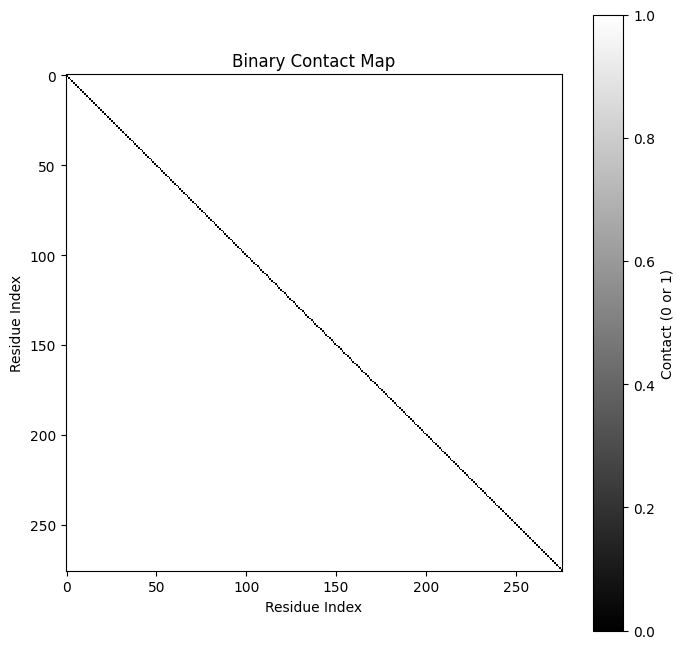

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import math

def vector_to_contact_map(vec):
    """
    Converts a vector of pairwise contact values into a symmetric contact map matrix.
    
    Args:
        vec (np.ndarray): 1D array of length L, where L = N*(N-1)/2.
    
    Returns:
        contact_map (np.ndarray): 2D symmetric array of shape (N, N).
    """
    num_pairs = vec.shape[0]
    # Calculate N using the quadratic formula: N = (1 + sqrt(1+8L)) / 2
    N = int((1 + math.sqrt(1 + 8 * num_pairs)) / 2)
    
    # Initialize an empty contact map matrix
    contact_map = np.zeros((N, N))
    
    # Get indices for the upper triangle (excluding the diagonal)
    triu_indices = np.triu_indices(N, k=1)
    
    # Fill the upper triangle with the vector values
    contact_map[triu_indices] = vec
    
    # Mirror the upper triangle to the lower triangle to make it symmetric
    contact_map = contact_map + contact_map.T
    
    return contact_map

# Example usage:
# Let's say `contact_vec` is your vector with shape (37950,). Replace this with your actual data.
contact_vec = np.random.rand(37950)  # This is a placeholder

# Convert the vector to a contact map matrix
contact_map = vector_to_contact_map(contact_maps[900].reshape(-1))

# Visualize the contact map using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(contact_map, cmap='gray', interpolation='nearest')
plt.title("Binary Contact Map")
plt.xlabel("Residue Index")
plt.ylabel("Residue Index")
plt.colorbar(label="Contact (0 or 1)")
plt.show()

In [2]:
from Bio.PDB import PDBParser, PPBuilder

# Replace with your PDB file path
pdb_file = "./data/MD/dev_data/r1/1k5n_A.pdb"

# Create a PDB parser object
parser = PDBParser(QUIET=True)

# Parse the structure from the PDB file
structure = parser.get_structure("protein", pdb_file)

# Initialize the polypeptide builder
ppb = PPBuilder()

# Extract sequences from all chains in the structure
for model in structure:
    for chain in model:
        # Build polypeptides for the chain (could be more than one segment)
        polypeptides = ppb.build_peptides(chain)
        for poly_index, poly in enumerate(polypeptides):
            sequence = poly.get_sequence()
            print(f"Chain {chain.id} (segment {poly_index}): {sequence}")

Chain   (segment 0): GSHSMRYFHTSVSRPGRGEPRFITVGYVDDTLFVRFDSDAASPREEPRAPWIEQEGPEYWDRETQICKAKAQTDREDLRTLLRYYNQSEAGSHTLQNMYGCDVGPDGRLLRGYHQHAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRAYLEGECVEWLRRYLENGKETLQRADPPKTHVTHHPISDHEATLRCWALGFYPAEITLTWQRDGEDQTQDTELVETRPAGDRTFQKWAAVVVPSGEEQRYTCHVQHEGLPKPLTLRWEP
